In [1]:
import numpy as np
from numpy import savez_compressed
from numpy import load
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import linalg as LA

import cv2
import os

# FIXME without appending sys.path make it more generic
import sys

#sys.path.append("../../../")
from elastica import *


# Import Wrappers
from elastica.wrappers import BaseSystemCollection, Constraints, Forcing

# Import Cosserat Rod Class
from elastica.rod.cosserat_rod import CosseratRod

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces

# Import Timestepping Functions
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate

In [2]:

from elastica import NoForces
from numba import njit


class EndpointTangentForces(NoForces):
    def __init__(self, end_force, normal_vector):
        super(EndpointTangentForces, self).__init__()
        self.end_force = end_force
        self.normal_vector = normal_vector

    def apply_forces(self, system, time: np.float64 = 0.0):
        end_tangent = system.tangents[..., -1]
        perpendicular = np.cross(self.normal_vector,end_tangent)
        perpendicular /= np.linalg.norm(perpendicular)
        system.external_forces[..., -1] += self.end_force*perpendicular
        #print(perpendicular)
        #print(end_tangent)

# EKI and subsampling scheme

First define forward operator.
This function generates the rod and makes the video

In [3]:
def GenTimoShearDyn(x):
    
    # setting up test params
    n_elem = 100 #number of elements in which rod is divided

    #Material properties
    #density = 1000
    density = x[1]
    nu = 0
    #E = 1e6
    E = x[0]
    # For shear modulus of 1e4, nu is 99!
    poisson_ratio = 0.5
    shear_modulus = E / (poisson_ratio + 1.0)

    #Geometry of the rod; location/orientation of rod and length and radius
    start = np.zeros((3,))
    direction = np.array([0.0, 0.0, 1.0])
    normal = np.array([0.0, 1.0, 0.0])
    base_length = 10
    base_radius = 0.25
    base_area = np.pi * base_radius ** 2
    
    unshearable_start = np.array([0.0, -1.0, 0.0])
    #Define run time of system
    final_time = 10.0
    dl = base_length / n_elem
    dt = 0.01 * dl
    total_steps = int(final_time / dt)
    print("Total steps to take", total_steps)
    
    
    time = 0.0


    class BeamSimulator(BaseSystemCollection, Constraints, Forcing):
        pass


    dynamic_update_sim = BeamSimulator()


    unshearable_rod_new = CosseratRod.straight_rod(
        n_elem,
        unshearable_start,
        direction,
        normal,
        base_length,
        base_radius,
        density,
        nu,
        E,
        #poisson_ratio=-0.85,
        shear_modulus=shear_modulus,
        #position=position,
    )
    #Apply force to the end
    origin_force = np.array([0.0, 0.0, 0.0])
    #end_force = E*base_area/400000
    end_force = 0.7
    ramp_up_time = 0.1
    
    normal_vector = normal
    
    dynamic_update_sim.append(unshearable_rod_new)
    dynamic_update_sim.constrain(unshearable_rod_new).using(
        OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
    )
    #dynamic_update_sim.add_forcing_to(unshearable_rod_new).using(
    #EndpointTangentForces, end_force, normal_vector
    #)
    dynamic_update_sim.add_forcing_to(unshearable_rod_new).using(
        EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
    )

    dynamic_update_sim.finalize()


    def run_and_update_plot(simulator, dt, start_time, stop_time, ax):
        from elastica.timestepper import extend_stepper_interface
        from elastica.timestepper.symplectic_steppers import PositionVerlet

        timestepper = PositionVerlet()
        do_step, stages_and_updates = extend_stepper_interface(timestepper, simulator)

        n_steps = int((stop_time - start_time) / dt)
        time = start_time
        for i in range(n_steps):
            time = do_step(timestepper, stages_and_updates, simulator, time, dt)
        ##Include the line below if you want to plot the image at every point and delete the if clause below
        #plot_timoshenko_dynamic(unshearable_rod_new, end_force, time, ax)
        return time


    def plot_timoshenko_dynamic(unshearable_rod, end_force, time, ax):
        import matplotlib.pyplot as plt
        from IPython import display

        ax.clear()
        #ax.grid(b=True, which="major", color="grey", linestyle="-", linewidth=0.25)

        ax.plot(
            unshearable_rod.position_collection[2, :],
            unshearable_rod.position_collection[0, :],
            "k-",
            
        )

        #ax.legend(prop={"size": 12}, loc="lower left")
        #ax.set_ylabel("Y Position (m)", fontsize=12)
        #ax.set_xlabel("X Position (m)", fontsize=12)
        #ax.set_title("Simulation Time: %0.2f seconds" % time)
        ax.set_xlim([0.0, 9.2])
        ax.set_ylim([-0.04, 0.045])#0.045
        #ax.set_ylim([x[1],0.045])
        plt.axis('off')


    %matplotlib inline
    import matplotlib.pyplot as plt
    from IPython import display

    evolve_for_time = 10.0
    update_interval = 1.0e-1

    # update the plot every 1 second
    fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    first_interval_time = update_interval + time
    last_interval_time = time + evolve_for_time 
    j=0
    for stop_time in np.arange(
        first_interval_time, last_interval_time + dt, update_interval
    ):
        time = run_and_update_plot(dynamic_update_sim, dt, time, stop_time, ax)
        if j==99:
            plot_timoshenko_dynamic(unshearable_rod_new, end_force, time, ax)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            name_image = './Beam_example/Beam'+ str(j) +'.jpg'
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
            plt.margins(0,0)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())
            plt.tight_layout()
            plt.savefig(name_image,bbox_inches='tight',pad_inches = 0)
        j=j+1
    plt.close()
    #segFrames()
    return dynamic_update_sim

## Next block loads and segments video into frames

In [4]:
from sklearn.preprocessing import normalize

def ForwardTimoschInvProb_opti(param):
    dynamic_update_sim = GenTimoShearDyn(param)
    i=99
    name_image_1='./Beam_example/Beam'+ str(i) + '.jpg'
    sol=cv2.imread(name_image_1)
    return sol

def potential(param,G,data,beta,info):
    img1=G(param)
    img2=data
    
    #Get dimensions
    rows_A,cols_A,_ = img1.shape
    rows_B,cols_B,_ = img2.shape

    #Translation of images; depends on where the force pushes the wire to
    #thresh1,thresh2=translation_upper_left(img1,img2)
    thresh1,thresh2=translation_lower_left(img1,img2)

    #Distance transformation
    img1_dist = cv2.distanceTransform(thresh1,cv2.DIST_L2,cv2.DIST_MASK_PRECISE)
    img2_dist = cv2.distanceTransform(thresh2,cv2.DIST_L2,cv2.DIST_MASK_PRECISE)    

    img1=img1_dist.reshape((-1, 1), order="F")
    img2=img2_dist.reshape((-1, 1), order="F")

    norm_cons=1/(rows_A*rows_B)
    
    res = norm_cons*(0.5*LA.norm(img1-img2)**2+0.5*beta*LA.norm(img1)**2)
    
    # display information
    if info['Nfeval']%1 == 0:
        #print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}  {5: 3.6f}'.format(info['Nfeval'], X[0], X[1], X[2], X[3], res))
        print(param[0])#, param[1], param[2], param[3], res)
    info['Nfeval'] += 1
    
    return res
    

#Translate images so that rod starts in upper left/lower left corner. Depending on which direction we apply the force to

def translation_upper_left(img1,img2):
    rows_A,cols_A,_ = img1.shape
    rows_B,cols_B,_ = img2.shape
    gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret1, thresh1 = cv2.threshold(gray1,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret2, thresh2 = cv2.threshold(gray2,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #Translate images upwards
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    ys1,xs1 =np.where(thresh1==0)
    ys2,xs2 =np.where(thresh2==0)


    min_row1=np.min(ys1)
    min_row2=np.min(ys2)
    T1 = np.float32([[1, 0, 0], [0, 1, -min_row1]])
    T2 = np.float32([[1, 0, 0], [0, 1, -min_row2]])
    img_translation_comp1 = cv2.warpAffine(thresh1, T1, (width1, height1))
    img_translation_comp2 = cv2.warpAffine(thresh2, T2, (width2, height2))


    #Set pixels on bottom to white, are initially now black due to translation
    img_translation_comp1[height1-min_row1:height1,:]=255
    img_translation_comp1[height1-min_row1:height1,:]=255
    thresh1=img_translation_comp1
    thresh2=img_translation_comp2



    return thresh1,thresh2

def translation_lower_left(img1,img2):
    rows_A,cols_A,_ = img1.shape
    rows_B,cols_B,_ = img2.shape
    gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret1, thresh1 = cv2.threshold(gray1,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret2, thresh2 = cv2.threshold(gray2,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #Translate images downwards
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    ys1 =np.where(thresh1[:,0]==0)
    ys2 =np.where(thresh2[:,0]==0)


    max_row1=np.max(ys1)
    max_row2=np.max(ys2)
    

    #T1 = np.float32([[1, 0, -min_col1], [0, 1, height1-max_row1]])
    T1 = np.float32([[1, 0, 0], [0, 1, height1-max_row1]])
    T2 = np.float32([[1, 0, 0], [0, 1, height2-max_row2]])
    #T2 = np.float32([[1, 0, -min_col2], [0, 1, height2-max_row2]])

    img_translation_comp1 = cv2.warpAffine(thresh1, T1, (width1, height1))
    img_translation_comp2 = cv2.warpAffine(thresh2, T2, (width2, height2))

    #Set new pixels at the starting rods to white, are initially black due to translation
    img_translation_comp1[0:height1-max_row1,:]=255
    img_translation_comp2[0:height2-max_row2,:]=255
    
    thresh1=img_translation_comp1
    thresh2=img_translation_comp2


    return thresh1,thresh2

## Define forward operator for Kalman inversion

-gen_timosh_eki generates an image from the given parameter and transforms it into vector form
<br>
-rightSideODE_subsamp and rightSideODE_subsamp correspond to the right hand sides of the ODEs that we want to solve.

In [8]:
from scipy.integrate import odeint
from odeintw import odeintw

#Generate image from given parameter and transform it into vector form
def gen_timosch_eki(param):
    
    dynamic_update_sim = GenTimoShearDyn(param)
    i=99
    name_image_1='./Beam_example/Beam'+ str(i) + '.jpg'
    img1=cv2.imread(name_image_1)
    #img1=cv2.resize(img1,(750,600))
    img1=cv2.resize(img1,(705,555))
    img2=img1



    #Translation of images
    #thresh1,thresh2=translation_upper_left(img1,img2)
    thresh1,thresh2=translation_lower_left(img1,img2)

    #Distance transformation
    img1_dist = cv2.distanceTransform(thresh1,cv2.DIST_L2,cv2.DIST_MASK_PRECISE)
    #img2_dist = cv2.distanceTransform(thresh2,cv2.DIST_L2,cv2.DIST_MASK_PRECISE)  
    
    scaling_h, scaling_w = img1_dist.shape
    scalar = scaling_h*scaling_w
    
    img_dist = 1/scalar*img1_dist.reshape((-1, 1), order="F")
    
    return img_dist

def rightSideODE(u,t,Gamma,fwop,J,y,k,beta):
    u_mean = u.mean(1)
    d,bla = u.shape
    Gu=np.zeros((k,J))
    Fu=np.zeros((k+d,J))
    z=np.concatenate((y,np.zeros((d,1))),axis=0)

    for j in range(1,J+1):
        Gu[:,j-1]=fwop(u[:,j-1]).ravel()

    Fu=np.concatenate((Gu,np.sqrt(beta)*u),axis=0)
    Fu_mean = Fu.mean(1)
    Gu_mean = Gu.mean(1)
    res=np.zeros((d,J))
    print(t)
    C_uG=np.zeros((d,k))
    C_uF=np.zeros((d,k+d))

    for i in range(1,J+1):
        inter_G=Gu[:,i-1]-Gu_mean
        inter_G = inter_G[:,np.newaxis]
        inter_u=u[:,i-1]-u_mean
        inter_u = inter_u[:,np.newaxis]
        inter_F=Fu[:,i-1]-Fu_mean
        inter_F = inter_F[:,np.newaxis]
        C_uF=C_uF+inter_u@inter_F.T
        C_uG=C_uG+inter_u@inter_G.T

    C_uG=C_uG/J
    C_uF=C_uF/J

    for j in range(1,J+1):
        test=Fu[:,j-1].reshape(-1,1)
        inter2=test-z
        interm=-C_uF@inter2
        res[:,j-1]=interm.reshape((d,))       

        
    return res

def rightSideODE_subsamp(u,t,Gamma,fwop,J,y,k,beta,jumptimes,batch_orig,N_sub):
    k=len(y)
    index=k//N_sub
    u_mean = u.mean(1)
    d,bla = u.shape
    Gu=np.zeros((k,J))
    Fu=np.zeros((index+d,d))
    res=np.zeros((d,J))
    Gu_sub=np.zeros((index,J))
    print(t)
    for j in range(1,J+1):
        Gu[:,j-1]=fwop(u[:,j-1]).ravel()

    #Define which time and therefore which batch to use    
    #-------------------------
    time_ind=len(jumptimes[jumptimes<=t])-1
    batch=batch_orig[time_ind]
    #-------------------------
    
    Gu_sub=Gu[((batch-1)*index):(index*batch),:]
    y_sub=y[((batch-1)*index):(index*batch)]
    z=np.concatenate((y_sub,np.zeros((d,1))),axis=0)
    Fu=np.concatenate((Gu_sub,np.sqrt(beta/N_sub)*u),axis=0)
    Fu_mean = Fu.mean(1)
    C_uF=np.zeros((d,index+d))

    for i in range(1,J+1):
        inter_u=u[:,i-1]-u_mean
        inter_u = inter_u[:,np.newaxis]
        inter_F=Fu[:,i-1]-Fu_mean
        inter_F = inter_F[:,np.newaxis]
        C_uF=C_uF+inter_u@inter_F.T
        
    C_uF=C_uF/J
    for j in range(1,J+1):
        test=Fu[:,j-1].reshape(-1,1)
        inter2=test-z
        interm=-C_uF@inter2
        res[:,j-1]=interm.reshape((d,))       
    return res


    

## Define functions to run EKI
-linear_waiting_time is a function to generate random waiting times for the subsampling scheme for a linear decaying learning rate. It follows the distribution until time the time given by the variable interm. From interm until T. We use equidistant changing times. Those can be adapted in the algorithm.
<br>
-EnKF_Timo and EnKF_Timo_subsamp execute the EKI and Subsampling scheme

In [9]:
import os
import random
import array
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def EnKf_Timo(data,u_0,Gamma,J,beta,T):
    d,J=u_0.shape
    k=len(data)

    timePoints=np.linspace(0,T,20)
    u=odeintw(rightSideODE,u_0,timePoints,args=(Gamma,gen_timosch_eki,J,data,k,beta),full_output=1,hmin=0.1,atol=10)
            
    return u

def linear_waiting_time(a,b,interm,T,N_sub):
    batch=np.array([random.randint(1,N_sub)],dtype='int')
    t_0=0
    jumptimes=np.array([t_0])
    x=np.linspace(1,N_sub,N_sub, dtype='int')
    jumptimes_long=np.linspace(interm,T,100)
    batch_long=np.array([random.randint(1,N_sub)],dtype='int')
    k=1
    if interm<T:
        while t_0<interm:
            x_new=x
            y=random.uniform(0,1)
            index=batch[k-1]-1
            t=(-a*t_0-b+np.sqrt((a*t_0+b)**2-2*a*np.log(1-y)))/a
            x_new=np.delete(x_new,index)
            batch=np.append(batch,random.choice(x_new))
            t_0=t_0+t
            jumptimes=np.append(jumptimes,t_0)
            k=k+1
        jumptimes=np.delete(jumptimes,-1)
        batch=np.delete(batch,-1)
        k=1
        for j in range(1,len(jumptimes_long)):
            x_new=x
            y=random.uniform(0,1)
            index=batch_long[k-1]-1
            t=(-a*t_0-b+np.sqrt((a*t_0+b)**2-2*a*np.log(1-y)))/a
            x_new=np.delete(x_new,index)
            batch_long=np.append(batch_long,random.choice(x_new))
            k=k+1
        batch=np.append(batch,batch_long)
        jumptimes=np.append(jumptimes,jumptimes_long)
    else:
         while t_0<interm:
            x_new=x
            y=random.uniform(0,1)
            index=batch[k-1]-1
            t=(-a*t_0-b+np.sqrt((a*t_0+b)**2-2*a*np.log(1-y)))/a
            x_new=np.delete(x_new,index)
            batch=np.append(batch,random.choice(x_new))
            t_0=t_0+t
            jumptimes=np.append(jumptimes,t_0)
            k=k+1
    return jumptimes, batch

def EnKf_Timo_subsamp(data,N_sub,u_0,Gamma,J,beta,interm,T,a,b):
    d,J=u_0.shape
    k=len(data)

    timePoints=np.linspace(0,T,20)

    [jumptimes,batch]=linear_waiting_time(a,b,interm,T,N_sub)
    u_res=odeintw(rightSideODE_subsamp,u_0,timePoints,args=(Gamma,gen_timosch_eki,J,data,k,beta,jumptimes,batch,N_sub),hmin=0.01,atol=10)

    return u_res

### Run Kalman inversion

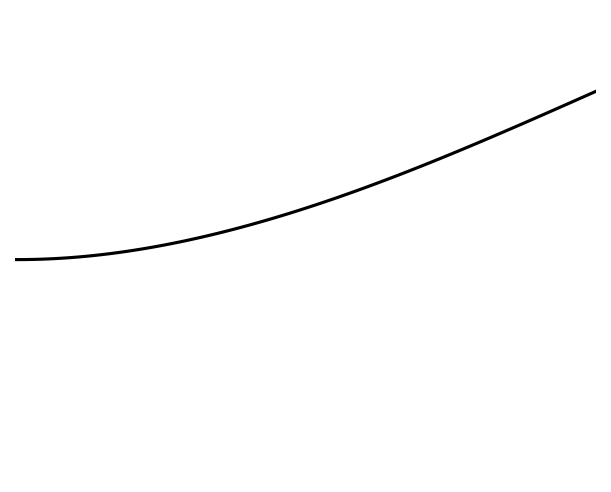

In [10]:
import cv2
from numpy.linalg import inv
from scipy.linalg import block_diag
from numpy import *

#Original image
name_image_1='./RealTimeFotos/1_9.jpeg'

img1 = cv2.imread(name_image_1)
img1=cv2.resize(img1,(705,555))
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,120,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) 
img1_dist = cv2.distanceTransform(thresh,cv2.DIST_L2,cv2.DIST_MASK_PRECISE)

scaling_h, scaling_w = img1_dist.shape
scalar = scaling_h*scaling_w

data = 1/scalar*img1_dist.reshape((-1, 1), order="F")

Gamma=np.eye(len(data))



#Set Parameters
J=3
N=2 #amount of times algorithm iterates

#Choose initial ensemble as solution parameters that are perturbed, change amount of particles or how you choose them.
param=np.zeros(2)
param[0]=1e5
param[1]=2000
param_ens=np.tile(param,(J, 1))
noise = np.random.normal(0, 100, param_ens.shape)
#noise=0
param_inens=(param_ens+noise).T
#param_inens=[[1e5,1.5e5,8e4,9e4],[100,300,500,700]]
param_inens[0,0]=3.5e6
param_inens[0,1]=5.5e6
param_inens[0,2]=4e6
#param_inens[0,3]=1.2e5
param_inens[1,0]=1900
param_inens[1,1]=1500
param_inens[1,2]=1100
#param_inens[1,3]=500
beta=0
N_sub=5
T=10000
interm=10
a=10
b=10

#Use EKI or subsampling approach
param_eki = EnKf_Timo(data,param_inens,Gamma,J,beta,T)
param_subsamp = EnKf_Timo_subsamp(data,N_sub,param_inens,Gamma,J,beta,interm,T,a,b)

# Evaluation of both methods

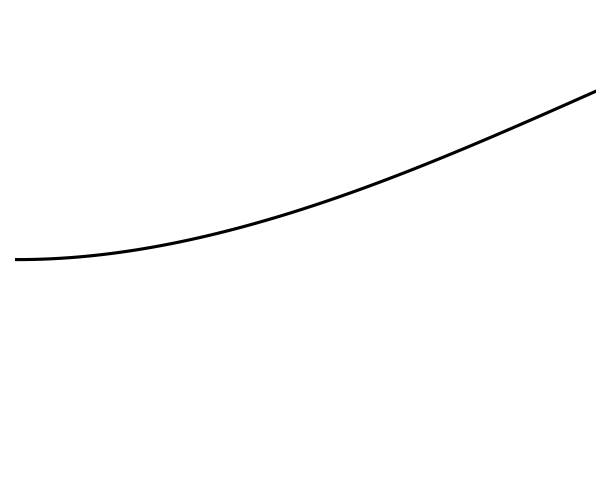

3997035.635467928


Corrupt JPEG data: premature end of data segment


Text(0.5, 1.0, 'Mean residual of the particles')

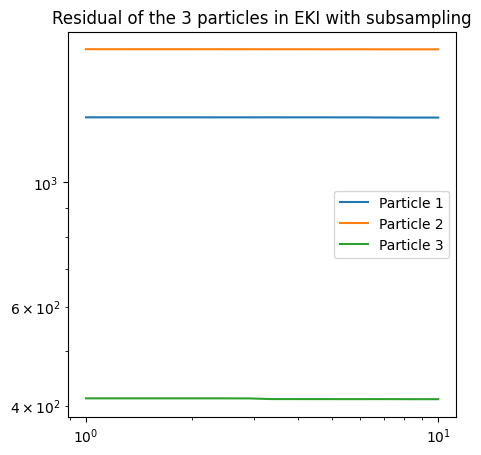

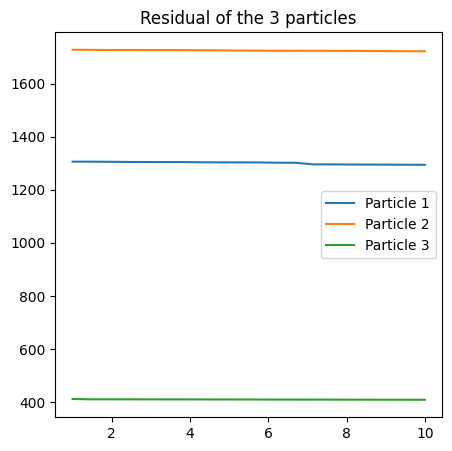

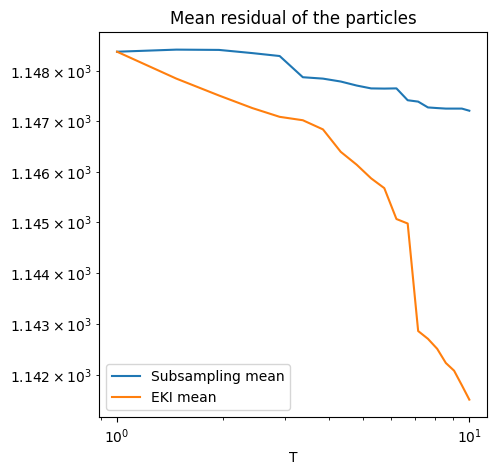

In [12]:
name_image_1='./RealTimeFotos/1_9.jpeg'
img1 = cv2.imread(name_image_1)
img1 = cv2.resize(img1,(705,555))

#Change the dimensions of the eki solution, since it gives us the full vector ouput
param_eki=param_eki[0]
times,dim,J=np.shape(param_subsamp)
N=times
res_subsamp=np.zeros((N,J))
res_eki=np.zeros((N,J))
for n in range(1,N+1):
    for j in range(1,J+1):
        res_subsamp[n-1,j-1]=potential(param_subsamp[n-1,:,j-1],ForwardTimoschInvProb_opti,img1,beta,{'Nfeval':0}) 
        res_eki[n-1,j-1]=potential(param_eki[n-1,:,j-1],ForwardTimoschInvProb_opti,img1,beta,{'Nfeval':0})
x=np.arange(N)
x=np.linspace(1,T,N)

#Plot residuals; subsampling
fig, ax = plt.subplots(figsize=(5, 5))
plt.loglog(x,res_subsamp,label=['Particle 1','Particle 2','Particle 3'])
leg = ax.legend();
plt.title("Residual of the 3 particles in EKI with subsampling")

# EKI
fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(x,res_eki,label=['Particle 1','Particle 2','Particle 3'])
leg = ax.legend();
plt.title("Residual of the 3 particles")

# Plot mean residuals of both methods in one image
fig, ax = plt.subplots(figsize=(5, 5))
plt.loglog(x,res_subsamp.mean(1),label='Subsampling mean')
plt.loglog(x,res_eki.mean(1),label='EKI mean')
leg = ax.legend();
plt.xlabel("T")
plt.title("Mean residual of the particles")

## Plot images of images of best particles and plot results in 1 image

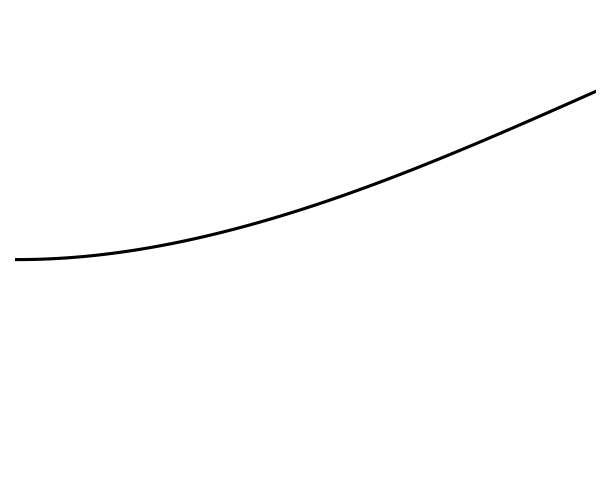

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


Text(0.5, 1.0, 'Subsampling solution and EKI solution')

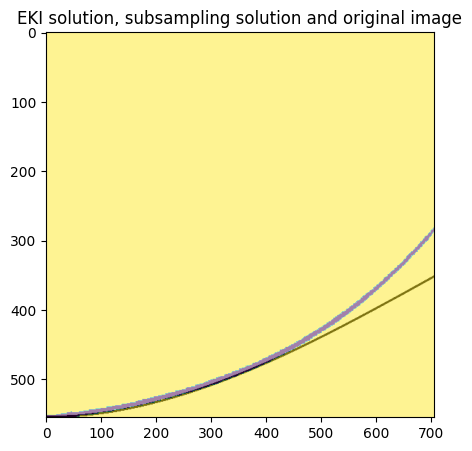

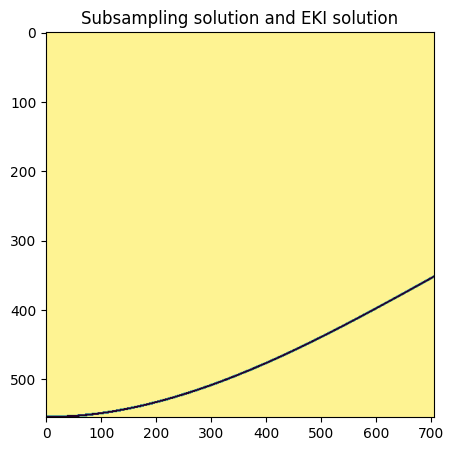

In [13]:
#First compute images with best parameter from EKI. Might need to change the particle here
x=ForwardTimoschInvProb_opti(param_eki[-1,:,2])

#Load image
i=99
name_image_1='./Beam_example/Beam'+ str(i) + '.jpg'
img_comp_kf = cv2.imread(name_image_1)
img_comp_kf = cv2.resize(img_comp_kf,(705,555))

#Do the same for subsampling
x=ForwardTimoschInvProb_opti(param_subsamp[-1,:,2])
name_image_1='./Beam_example/Beam'+ str(i) + '.jpg'
img_comp_sub = cv2.imread(name_image_1)
img_comp_sub = cv2.resize(img_comp_sub,(705,555))

#Original image
name_image_1='./RealTimeFotos/1_9.jpeg'
img_orig =cv2.imread(name_image_1)
img_orig = cv2.resize(img_orig,(705,555))


#Translation of images
#thresh1,thresh2=translation_upper_left(img1,img2)
thresh_kf,thresh_subsamp=translation_lower_left(img_comp_kf,img_comp_sub)
thresh_orig,thresh_test=translation_lower_left(img_orig,img_comp_sub)

# First compare both computed solutions with the optimal solution
#fig = plt.subplots(figsize=(5, 5))
fig = plt.figure(figsize=(5, 5))
plt.imshow(thresh_kf,cmap='gray', vmin = 0, vmax = 255,aspect='auto')
plt.imshow(thresh_subsamp,cmap='gray', vmin = 0, vmax = 255,aspect='auto',alpha=0.5)
plt.imshow(thresh_orig,cmap='viridis', vmin = 0, vmax = 255,aspect='auto',alpha=0.5)
plt.title("EKI solution, subsampling solution and original image")

#Here we compare only the computed solutions
fig = plt.figure(figsize=(5, 5))
plt.imshow(thresh_subsamp,cmap='gray', vmin = 0, vmax = 255,aspect='auto')
plt.imshow(thresh_kf,cmap='viridis', vmin = 0, vmax = 255,aspect='auto',alpha=0.5)
plt.title("Subsampling solution and EKI solution")
